### CAM과 Grad-CAM 비교실험

In [120]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

#### GPU 메모리 동적 할당
- 로컬에서 실험 시 텐서플로우가 VRAM을 전체를 점유해 다른 외부 프로그램들이 셧다운 되는 상황이 발생해 동적 할당 설정함

In [152]:
# GPU 메모리 동적 할당

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.experimental.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # GPU 메모리 동적 할당
    except RuntimeError as e:
        print(e)


TensorFlow Version: 2.6.0
Num GPUs Available: 1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [153]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

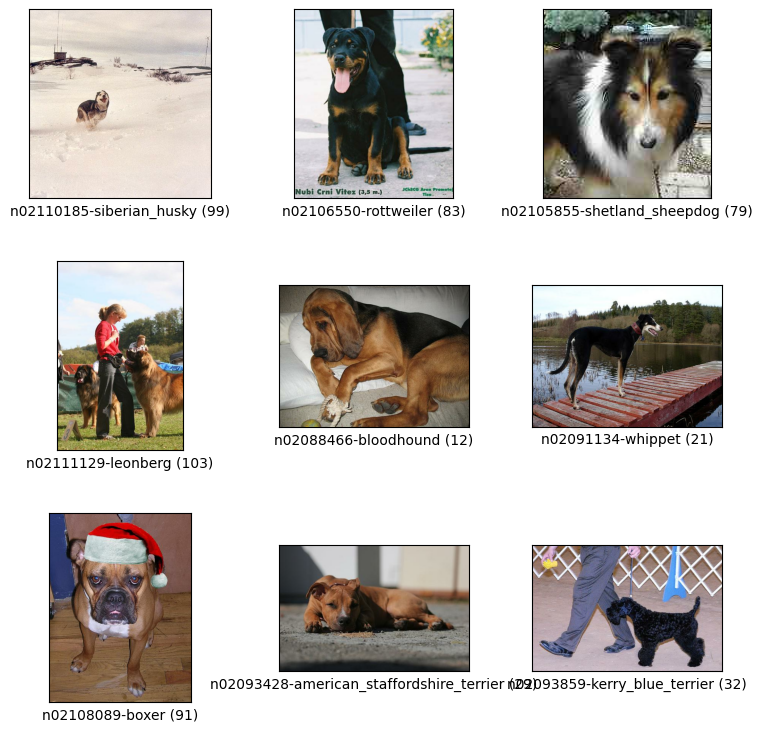

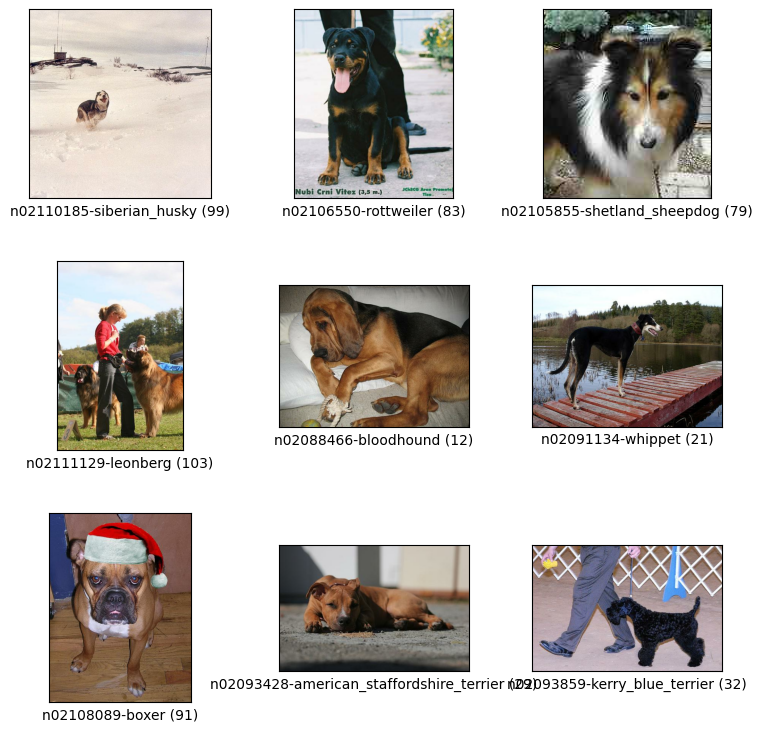

In [154]:
tfds.show_examples(ds_train, ds_info)

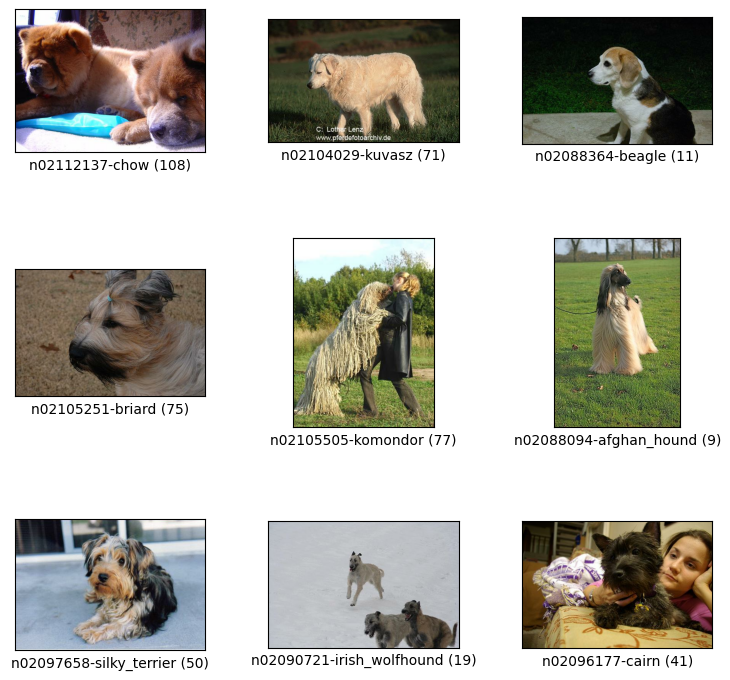

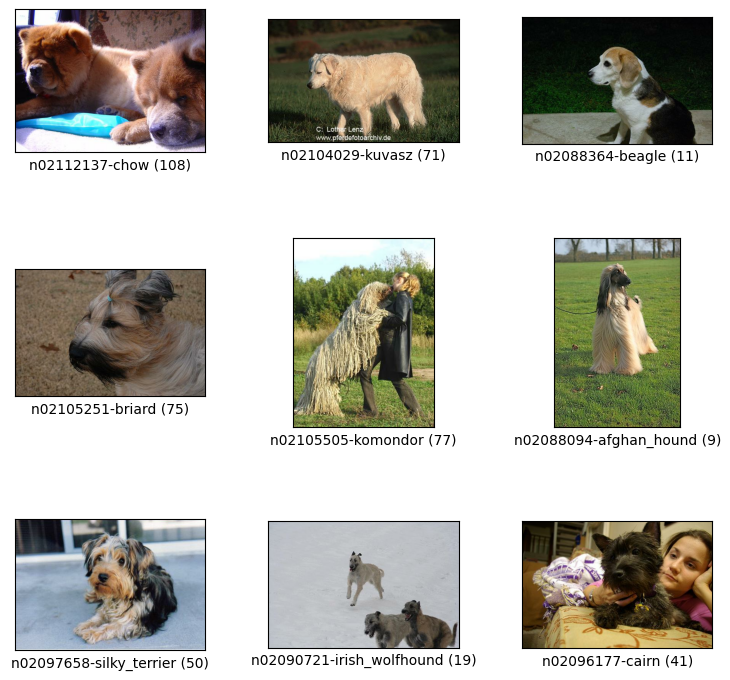

In [155]:
tfds.show_examples(ds_test, ds_info)

In [156]:
num_classes = ds_info.features["label"].num_classes
# 이후 모델의 마지막 dense 레이어를 위해 데이터셋의 레이블 가져오기

base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)

#base 모델의 마지막 레이어
x = base_model.output

#cam에서 학습하는 FCL의 weight를 위한 Dense layer
cam_weights = keras.layers.Dense(num_classes, use_bias=False, name = "cam_weights")(x)

#Softmax layer
preds = keras.layers.Activation('softmax')(cam_weights)

#base_model의 input과 preds를 output으로 하는 모델 만들기
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [157]:
cam_model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [158]:
'''
1. input은 tf.dataset에서의 데이터 개별 샘플을 의미하는 딕셔너리
2. 그 중 이미지를 가져와서 224 x 224 크기로 리사이즈
3. 리사이즈 한 이미지를 float32로 변환하고, 255로 나누어 정규화
4. 튜플로 리턴
'''

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']


'''
1.tf.data.Dataset 객체와 테스트 데이터셋 여부, 배치 사이즈 입력
2.map()은 데이터셋의 각 샘플에 특정 함수(정규화)를 적용한다.
3.batch()는 배치 사이즈로 나눠준다.
4.prefecth()는 GPU가 연산하는 동안 CPU가 다음 배치를 미리 로드할 수 있도록 하게 해준다.
'''

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls= tf.data.AUTOTUNE #병렬 처리 자동으로로
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


In [159]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
# take()로 첫번째 배치만 가져와서 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [160]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


In [161]:
'''
1. train dataset 선택
2. steps_per_epoch | 한 에포크당 훈령 데이터 셋을 몇번 업데이트 할지
3. validation_steps | 검증 스텝 개수는 얼마인지
4. epochs | 전체 학습 반복 횟수
5. validation_data | 검증 데이터셋 (test를 사용)
6. verbose | 학습 진행 상황 출력 방식
'''
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 52s 65ms/step - loss: 2.2635 - accuracy: 0.4315 - val_loss: 3.3487 - val_accuracy: 0.2032
Epoch 2/2
750/750 [==============================] - 45s 60ms/step - loss: 0.6186 - accuracy: 0.8375 - val_loss: 1.1507 - val_accuracy: 0.6583


In [188]:

import os

# 저장할 경로 설정
cam_model_path = os.path.join("~/aiffel", "cam_model1.h5")

# 모델 저장
cam_model.save(cam_model_path)

In [189]:
'''
1. 배치 하나를 가지고 와서
2. 텐서 형태가 아닌 넘파이 배열로 만들기
3. 이후 바운딩 박스, 레이블, 이미지 따로 저장
4. 근데 리턴은 안함... 이거 무슨 의미지?
5. 배치에 있는 하나의 샘플 리턴
'''

def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


67


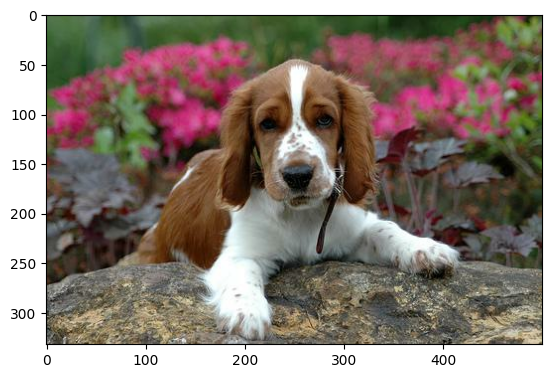

In [190]:
'''
1. 샘플 하나 가져와서 item 변수에 저장
2. 레이블과 이미지 출력하기
'''
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [191]:
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


In [192]:
'''
1. 원본 보호를 위해 샘플 deepcopy
2. 추후 원본 크기로 되돌리기 위해 w,h 저장
3. 정규화 적용후 리턴
'''

def generate_cam(model, item):
    item = copy.deepcopy(item) #원본 보호를 위한 deepcopy()
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    '''
    1. input층은 그대로 이용
    2. 기존 모델의 최종 예측과, 마지막 Conv layer를 출력
    '''
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-4].output, model.output])
	
    '''
	1. 모델의 입력 형태에 맞추도록 배치 차원 추가
	2. 배치 차원 제거하기
	3. 모델의 맨 마지막 층에서 weight 가져오기
	4. shape가 (h, w, channels) 인 conv_outputs에서 h, w 가져오기
	5. enumertate를 이용해서 인덱스와 배열 모두 가져오기
	6. w와 conv 커널을 곱한뒤 더해서 CAM 만들기
	7. 정규화 후 원본 사이즈로 resize
	'''

    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-2].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('슝=3')

슝=3


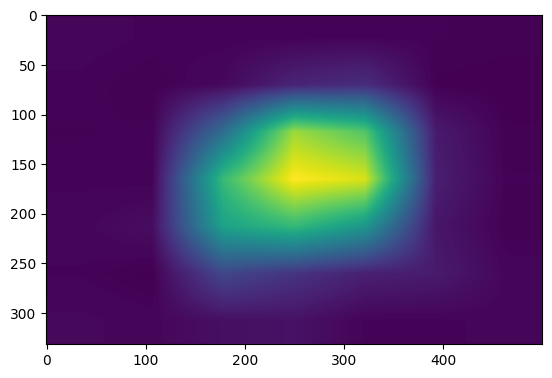

In [193]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [194]:
# 두 이미지 합성하기
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


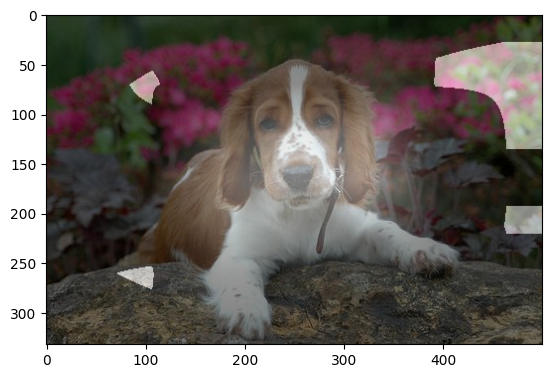

In [195]:
'''
1. 시각화를 위해 다시 int8로
2. CAM이미지를 RGB 3채널로 변환하기
3. 이후 원본 이미지와 합성 후 시각화하기
'''
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

108


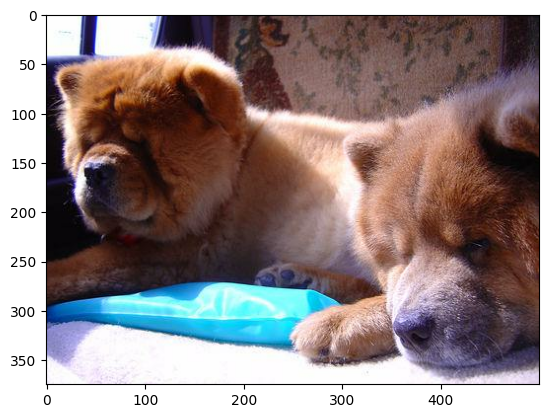

In [196]:
#gradcam을 위한 새로운 이미지 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [197]:
'''
1. 원본 보호 
'''


def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다. 모델이 출력한 확률값
        output = conv_output[0] # 원하는 layer의 output을 얻습니다 배치 차원을 제거하여 (H,W,C)로 바꾸기.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image) # ReLU 적용
    grad_cam_image /= np.max(grad_cam_image) # 정규화
    grad_cam_image = grad_cam_image.numpy() # 넘파이 배열로 바꾸기
    grad_cam_image = cv2.resize(grad_cam_image, (width, height)) #
    return grad_cam_image

print('슝=3')

슝=3


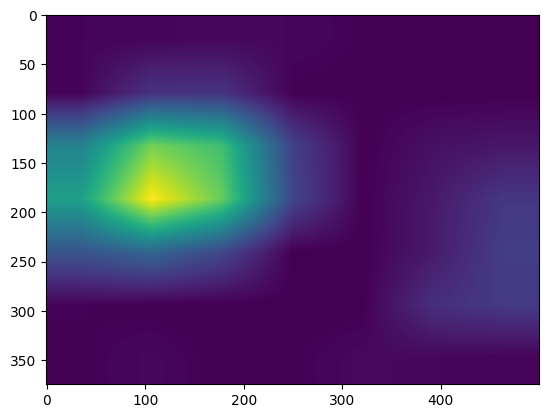

In [198]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

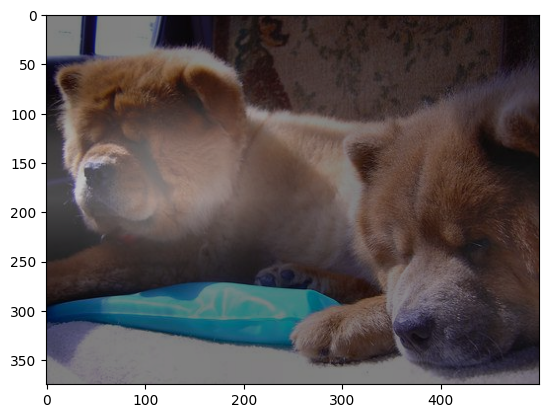

In [199]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(grad_blended_image)
plt.show()

In [200]:
def get_bbox(cam_image, score_thresh=0.05):
    """
    CAM 이미지에서 주어진 threshold를 적용하여 바운딩 박스를 계산하는 함수.

    Parameters:
        cam_image (numpy.ndarray): 활성화 맵 (Grad-CAM 또는 CAM 결과)
        score_thresh (float): 임계값 (기본값: 0.5)

    Returns:
        rect (numpy.ndarray): 최소 영역을 감싸는 바운딩 박스 좌표 (4x2)
    """
    cam_copy = copy.deepcopy(cam_image)  # 원본 cam_image 보호

    # Threshold 적용
    cam_copy[cam_copy <= score_thresh] = 0
    cam_copy = (cam_copy * 255).astype(np.uint8)

    # 컨투어 검출
    contours, _ = cv2.findContours(cam_copy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 컨투어가 없는 경우 예외 처리 (빈 리스트 방지)
    if not contours:
        return np.array([[0, 0], [0, 0], [0, 0], [0, 0]])  # 빈 바운딩 박스 반환

    # 가장 큰 컨투어 선택 (가장 넓은 활성화 영역)
    cnt = max(contours, key=cv2.contourArea)

    # 최소 영역을 감싸는 바운딩 박스 계산
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)  # 정수 좌표 변환

    return rect

In [201]:
rect = get_bbox(cam_image)
grad_rect = get_bbox(grad_cam_image)

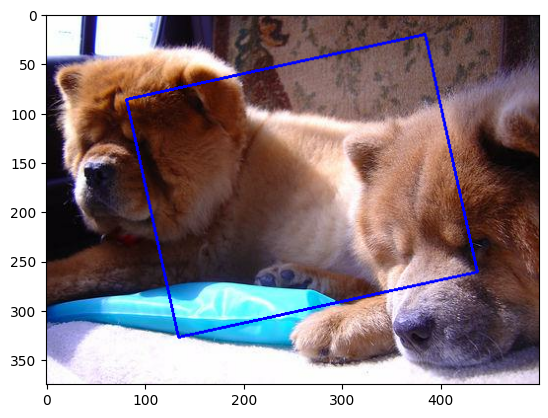

In [202]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [203]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


In [204]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.05333333333333334, 0.162, 0.872, 0.874]

In [205]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

In [206]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


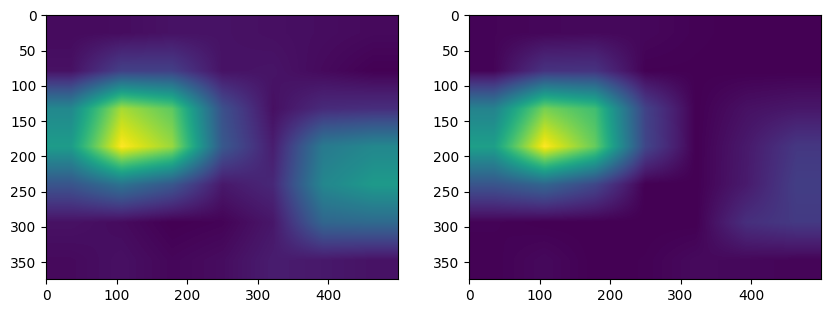

In [207]:
#gradcam과 cam 액티베이션 맵 비교

grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
cam_image = generate_cam(cam_model, item)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cam_image)
plt.subplot(1, 2, 2)
plt.imshow(grad_cam_image)
plt.show()

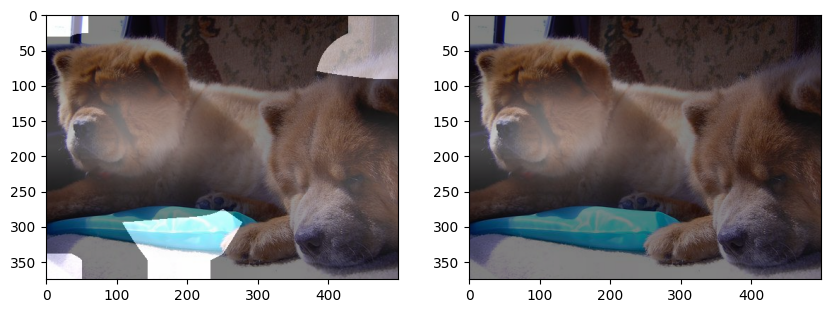

In [208]:
#gradcam과 cam 이미지 비교

grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(blended_image)
plt.subplot(1, 2, 2)
plt.imshow(grad_blended_image)
plt.show()

### 이 이미지에서는, 오른쪽 강아지에 대해서도 조금 활성화 된 CAM이 더 낫다고 생각했다.

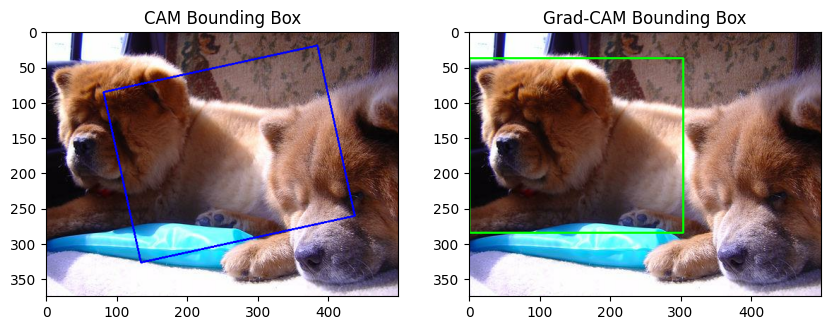

In [209]:
image_cam = copy.deepcopy(item['image'])  # CAM 바운딩 박스용 복사본
image_gradcam = copy.deepcopy(item['image'])  # Grad-CAM 바운딩 박스용 복사본

image_cam = cv2.drawContours(image_cam, [rect], 0, (0,0,255), 2)  # CAM (빨간색)
image_gradcam = cv2.drawContours(image_gradcam, [grad_rect], 0, (0,255,0), 2)  # Grad-CAM (초록색)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_cam)  # CAM 바운딩 박스 시각화
plt.title("CAM Bounding Box")

plt.subplot(1, 2, 2)
plt.imshow(image_gradcam)  # Grad-CAM 바운딩 박스 시각화
plt.title("Grad-CAM Bounding Box")

plt.show()

#### 오른쪽 강아지가 조금 더 활성화 된 CAM이 바운딩 박스를 중간에 잡아버려서, 현재 코드 기준으로는 Grad-CAM의 결과가 더 나아보인다.

In [210]:
#gradcam과 cam의 iou 비교

pred_bbox = rect_to_minmax(rect, item['image'])
grad_bbox = rect_to_minmax(grad_rect, item['image'])

print("IoU of CAM and GT bbox:", get_iou(pred_bbox, item['objects']['bbox'][0]))
print("IoU of GradCAM and GT bbox:", get_iou(grad_bbox, item['objects']['bbox'][0]))

IoU of CAM and GT bbox: 0.39610787236818845
IoU of GradCAM and GT bbox: 0.09893982512712916


In [211]:
# threshold 비교실험

def get_bbox_new(cam_image, score_thresh=0.5):
    """
    CAM 이미지에서 주어진 threshold를 적용하여 바운딩 박스를 계산하는 함수.

    Parameters:
        cam_image (numpy.ndarray): 활성화 맵 (Grad-CAM 또는 CAM 결과)
        score_thresh (float): 임계값 (기본값: 0.5)

    Returns:
        rect (numpy.ndarray): 최소 영역을 감싸는 바운딩 박스 좌표 (4x2)
    """
    cam_copy = copy.deepcopy(cam_image)  # 원본 cam_image 보호

    # Threshold 적용
    cam_copy[cam_copy <= score_thresh] = 0
    cam_copy = (cam_copy * 255).astype(np.uint8)

    # 컨투어 검출
    contours, _ = cv2.findContours(cam_copy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 컨투어가 없는 경우 예외 처리 (빈 리스트 방지)
    if not contours:
        return np.array([[0, 0], [0, 0], [0, 0], [0, 0]])  # 빈 바운딩 박스 반환

    # 가장 큰 컨투어 선택 (가장 넓은 활성화 영역)
    cnt = max(contours, key=cv2.contourArea)

    # 최소 영역을 감싸는 바운딩 박스 계산
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)  # 정수 좌표 변환

    return rect


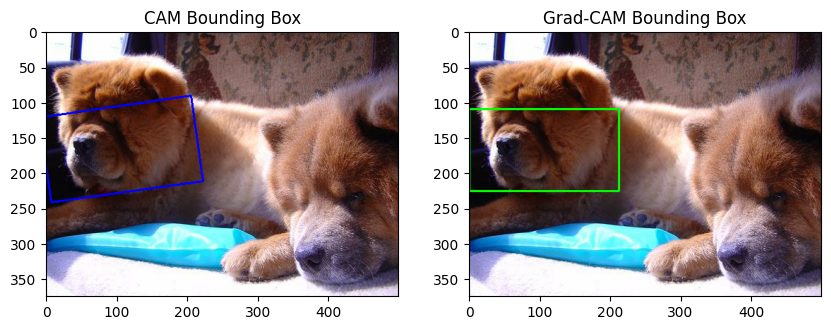

In [212]:
# CAM과 Grad-CAM의 바운딩 박스 가져오기
rect = get_bbox_new(cam_image)
grad_rect = get_bbox_new(grad_cam_image)

# 원본 이미지를 별도로 복사하여 CAM과 Grad-CAM 각각 독립적으로 표시
image_cam = copy.deepcopy(item['image'])  # CAM용 이미지 복사본
image_gradcam = copy.deepcopy(item['image'])  # Grad-CAM용 이미지 복사본

# CAM (빨간색) 바운딩 박스 그리기
cv2.drawContours(image_cam, [rect], 0, (0,0,255), 2)

# Grad-CAM (초록색) 바운딩 박스 그리기
cv2.drawContours(image_gradcam, [grad_rect], 0, (0,255,0), 2)

# 두 개의 이미지 비교 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_cam)  # OpenCV는 BGR이므로 RGB로 변환
plt.title("CAM Bounding Box")

plt.subplot(1, 2, 2)
plt.imshow(image_gradcam)  # OpenCV는 BGR이므로 RGB로 변환
plt.title("Grad-CAM Bounding Box")

plt.show()

Threshold를 높여보니, 두 모델 다 얼굴 표현이 잘 된 왼쪽 강아지의 모습에 집중한 모습이었다.

### 회고

1. 모델 구조를 만들 때, GAP이후에 하나 더 추가해야 하는지 헷갈려서 LMS에 비해 Dense 레이어가 하나 더 많은 실수를 해서 레이어를 받아오는 코드의 인덱스를 수정했다.
2. 뽑아온 샘플이 하필 두마리가 있는 형태라, 바운딩 박스를 하나 그리는 기존 코드로는 한계가 있는 것 같았다.
3. 바운딩 박스를 여러개 만드는 코드나, 여러 스케일에서 추가 실험을 진행하고 싶다.